# Classification of tasks per group

In [2]:
import pickle 
import pandas as pd 
import numpy as np 
from pathlib import Path 
from DMD import DMD

with open(str(Path.cwd().parent / 'results' / 'task_classification' / 'indiv_classification_tasks_eeg.pkl'), 'rb') as handle:
    indiv_classi_eeg = pickle.load(handle) 

with open(str(Path.cwd().parent / 'results' / 'task_classification'/ 'indiv_classification_tasks_cf_force.pkl'), 'rb') as handle:
    indiv_classi_force = pickle.load(handle) 

labels = ['Steady right', 'Sine right', 'Steady left', 'Sine left']

experts_eeg = np.mean([np.mean(indiv_classi_eeg[k].conf_mat, axis = 0) for k in indiv_classi_eeg if "e" in k], axis = 0)
conf_mat_experts_eeg = pd.DataFrame(experts_eeg, index = labels, columns = labels)
conf_mat_experts_eeg.index.name = 'Actual class'
conf_mat_experts_eeg.columns.name = 'Predicted class'

experts_force = np.mean([np.mean(indiv_classi_force[k], axis = 0) for k in indiv_classi_force if "e" in k],axis = 0)
conf_mat_experts_force = pd.DataFrame(experts_force, index = labels, columns = labels)
conf_mat_experts_force.index.name = 'Actual class'
conf_mat_experts_force.columns.name = 'Predicted class'

novices_eeg = np.mean([np.mean(indiv_classi_eeg[k].conf_mat, axis = 0) for k in indiv_classi_eeg if "n" in k],axis = 0)
conf_mat_novices_eeg = pd.DataFrame(novices_eeg, index = labels, columns = labels)
conf_mat_novices_eeg.index.name = 'Actual class'
conf_mat_novices_eeg.columns.name = 'Predicted class'

novices_force = np.mean([np.mean(indiv_classi_force[k], axis = 0) for k in indiv_classi_force if "n" in k],axis = 0)
conf_mat_novices_force = pd.DataFrame(novices_force, index = labels, columns = labels)
conf_mat_novices_force.index.name = 'Actual class'
conf_mat_novices_force.columns.name = 'Predicted class'


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


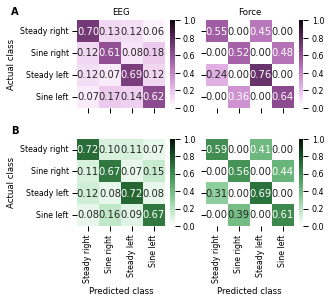

In [3]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt 
cm = 1/2.54
cmap_exp = sns.cubehelix_palette(n_colors = 50, start=0.4, rot=0, dark=0.05, gamma = 1, hue = 1, light=1)
cmap_nov = sns.cubehelix_palette(n_colors = 50, start=2.01, rot=0, dark=0.05, gamma = 1, hue = 1, light=1)
sns.set_context('paper', font_scale = .9)
fig, axes = plt.subplots(2,2, figsize = (12*cm, 11*cm))
plt.rcParams['mathtext.default'] = 'rm'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'Arial'

sns.heatmap(conf_mat_experts_eeg, cmap= cmap_exp, annot=True, fmt='.2f', vmin = 0, vmax = 1, ax = axes[0,0])
sns.heatmap(conf_mat_novices_eeg, cmap= cmap_nov, annot=True, fmt='.2f', vmin = 0, vmax = 1, ax = axes[1,0])
sns.heatmap(conf_mat_experts_force, cmap= cmap_exp, annot=True, fmt='.2f', vmin = 0, vmax = 1, ax = axes[0,1])
sns.heatmap(conf_mat_novices_force, cmap= cmap_nov, annot=True, fmt='.2f', vmin = 0, vmax = 1, ax = axes[1,1])


axes[0,0].set_xticklabels([])
axes[0,0].set_xlabel('')
axes[0,0].set_title('EEG')
axes[0,1].set_xticklabels([])
axes[0,1].set_xlabel('')
axes[0,1].set_title('Force')
axes[0,1].set_yticklabels([])
axes[0,1].set_ylabel('')
axes[1,1].set_yticklabels([])
axes[1,1].set_ylabel('')
axes[0,0].text(-3, -0.25, "A", horizontalalignment='left', size='medium', color='black', weight='semibold')
axes[1,0].text(-3, -0.25, "B", horizontalalignment='left', size='medium', color='black', weight='semibold')
fig.tight_layout()
fig.savefig(str(Path.cwd().parent / 'Figures' / 'task_classification.svg'))

In [4]:
experts = {k:indiv_classi_eeg[k].metrics_ for k in indiv_classi_eeg if "e" in k}
novices = {k:indiv_classi_eeg[k].metrics_ for k in indiv_classi_eeg if "n" in k}

def create_res_df(dict, name):
    df = pd.DataFrame()
    df['accuracy'] = [np.mean([dict[d][i]['accuracy'] for i in range(10)]) for d in dict]
    df['f1'] = [np.mean([dict[d][i]['macro avg']['f1-score'] for i in range(10)]) for d in dict]
    df['precision'] = [np.mean([dict[d][i]['macro avg']['precision'] for i in range(10)]) for d in dict]
    df['recall'] = [np.mean([dict[d][i]['macro avg']['recall'] for i in range(10)]) for d in dict]
    df['group'] = name
    return(df)

results_eeg = pd.concat([create_res_df(experts, 'FME'),create_res_df(novices, 'NOV')])

In [5]:
from scipy.stats import shapiro

def test_normality(df, test, output = False):
    stats = []
    print(test) 
    for col in ['accuracy', 'f1', 'precision', 'recall']:
        print('%s:' %col)
        for g in  df.group.unique():
                data = df[df.group == g]
                data = data[col]
                stat , p = test(data)
                print('Group: %s / variable: %s / Statistics=%.3f, p=%.3f' % (g,col,stat, p)) 
                stats.append((stat,p))
        print('\n')
    if output == True:
        return(stats) 

test_normality(results_eeg, shapiro)

<function shapiro at 0x7f14ffa50ee0>
accuracy:
Group: FME / variable: accuracy / Statistics=0.933, p=0.161
Group: NOV / variable: accuracy / Statistics=0.950, p=0.319


f1:
Group: FME / variable: f1 / Statistics=0.935, p=0.171
Group: NOV / variable: f1 / Statistics=0.954, p=0.384


precision:
Group: FME / variable: precision / Statistics=0.927, p=0.119
Group: NOV / variable: precision / Statistics=0.958, p=0.448


recall:
Group: FME / variable: recall / Statistics=0.934, p=0.164
Group: NOV / variable: recall / Statistics=0.947, p=0.275




In [6]:
results_eeg_sumstat = results_eeg.groupby('group').describe().loc[:, (slice(None), ('mean','std'))]
results_eeg_sumstat.to_csv(str(Path.cwd().parent / 'results' / 'classification_report_tasks_eeg_stats.csv'))
results_eeg_sumstat

accuracy                  f1           precision              recall  \
           mean       std      mean       std      mean       std      mean   
group                                                                         
FME    0.658296  0.156388  0.651853  0.159219  0.675384  0.158377  0.658461   
NOV    0.695998  0.096778  0.688733  0.100556  0.708433  0.099725  0.695475   

                 
            std  
group            
FME    0.156576  
NOV    0.097259

In [25]:
from scipy.stats import ttest_ind, mannwhitneyu

def test_diff(df, test, output = False):
    stats = {}
    data_x = df[df.group == 'FME']
    data_y = df[df.group == 'NOV']
    for col in ['accuracy', 'f1', 'precision', 'recall']:
        x = data_x[col]
        y = data_y[col]
        stat , p = test(x,y)
        stats[col] = (stat,p)
    if output == True:
        return(stats)

stat = pd.DataFrame(test_diff(results_eeg, ttest_ind, output = True)).T
stat.columns = ['Statistical Value', 'p']
stat
    

,Statistical Value,p
accuracy,-0.955507,0.344922
f1,-0.912632,0.366772
precision,-0.822909,0.415320
recall,-0.935936,0.354787


In [8]:
with open(str(Path.cwd().parent / 'results' / 'task_classification' / 'indiv_classification_tasks_report_force.pkl'), 'rb') as handle:
   report = pickle.load(handle)

experts = {k:report[k] for k in report if "e" in k}
novices = {k:report[k] for k in report if "n" in k}

results_force = pd.concat([create_res_df(experts, 'FME'),create_res_df(novices, 'NOV')])
results_force_sum = results_force.groupby('group').describe().loc[:, (slice(None), ('mean','std'))]
results_force_sum.to_csv(str(Path.cwd().parent / 'results' / 'classification_report_tasks_force_stats.csv'))
results_force_sum

accuracy                  f1           precision              recall  \
           mean       std      mean       std      mean       std      mean   
group                                                                         
FME    0.617579  0.074192  0.589859  0.091303  0.615298  0.085671  0.617241   
NOV    0.613820  0.077136  0.588316  0.090734  0.611401  0.096857  0.614042   

                 
            std  
group            
FME    0.074277  
NOV    0.077131

In [9]:
test_normality(results_force, shapiro)

<function shapiro at 0x7f14ffa50ee0>
accuracy:
Group: FME / variable: accuracy / Statistics=0.967, p=0.662
Group: NOV / variable: accuracy / Statistics=0.961, p=0.501


f1:
Group: FME / variable: f1 / Statistics=0.951, p=0.356
Group: NOV / variable: f1 / Statistics=0.973, p=0.768


precision:
Group: FME / variable: precision / Statistics=0.968, p=0.678
Group: NOV / variable: precision / Statistics=0.968, p=0.655


recall:
Group: FME / variable: recall / Statistics=0.971, p=0.754
Group: NOV / variable: recall / Statistics=0.960, p=0.499




In [10]:
stat = pd.DataFrame(test_diff(results_force, ttest_ind, output = True)).T
stat.columns = ['Statistical Value', 'p']
stat

,Statistical Value,p
accuracy,0.162739,0.871523
f1,0.055556,0.955965
precision,0.139488,0.889747
recall,0.138398,0.890603


### Group level classification

In [33]:
with open('e_between_part_task_classification_report.pkl','rb') as f:
    experts = pickle.load(f) 

with open('n_between_part_task_classification_report.pkl','rb') as f:
    novices = pickle.load(f) 
def get_scores(dict):
    mean_scores = {}
    mean_scores['accuracy'] = [dict[i]['accuracy'] for i in range(10)]
    mean_scores['f1'] = [dict[i]['macro avg']['f1-score'] for i in range(10)]
    mean_scores['precision'] = [dict[i]['macro avg']['precision'] for i in range(10)]
    mean_scores['recall'] = [dict[i]['macro avg']['recall'] for i in range(10)]
    return(mean_scores)

novices = pd.DataFrame(get_scores(novices))
novices['group'] = 'novices'
experts = pd.DataFrame(get_scores(experts))
experts['group'] = 'experts'
df = pd.concat([experts,novices])
df.groupby('group').describe()

accuracy                                                              \
           count      mean       std       min       25%       50%       75%   
group                                                                          
experts     10.0  0.306778  0.034089  0.252888  0.286687  0.304326  0.326538   
novices     10.0  0.352460  0.021227  0.326343  0.334835  0.356000  0.363820   

                     f1            ... precision           recall            \
              max count      mean  ...       75%       max  count      mean   
group                              ...                                        
experts  0.371975  10.0  0.298041  ...  0.326699  0.373952   10.0  0.306802   
novices  0.394366  10.0  0.348266  ...  0.367618  0.403222   10.0  0.352086   

                                                                     
              std       min       25%       50%       75%       max  
group                                                                
experts  0.034061  0.253339  0.286759  0.303855  0.326547  0.372103  
novices  0.021229  0.325326  0.334094  0.356160  0.363484  0.394051  

[2 rows x 32 columns]

In [34]:
for d in [experts, novices]:
    print(d.group[0])
    for c in experts.columns[:-1]:
        print(f'{c}: {shapiro(experts[c])}')

experts
accuracy: ShapiroResult(statistic=0.9835708141326904, pvalue=0.9813910722732544)
f1: ShapiroResult(statistic=0.9463239312171936, pvalue=0.6252589821815491)
precision: ShapiroResult(statistic=0.9619513154029846, pvalue=0.8078740835189819)
recall: ShapiroResult(statistic=0.9828931093215942, pvalue=0.9787557721138)
novices
accuracy: ShapiroResult(statistic=0.9835708141326904, pvalue=0.9813910722732544)
f1: ShapiroResult(statistic=0.9463239312171936, pvalue=0.6252589821815491)
precision: ShapiroResult(statistic=0.9619513154029846, pvalue=0.8078740835189819)
recall: ShapiroResult(statistic=0.9828931093215942, pvalue=0.9787557721138)


In [35]:
print(f"accuracy:{ttest_ind(df[df.group == 'experts'].accuracy,df[df.group == 'novices'].accuracy)}")
print(f"f1:{ttest_ind(df[df.group == 'experts'].f1,df[df.group == 'novices'].f1)}")
print(f"recall:{ttest_ind(df[df.group == 'experts'].recall,df[df.group == 'novices'].recall)}")
print(f"precision:{ttest_ind(df[df.group == 'experts'].precision,df[df.group == 'novices'].precision)}")

accuracy:Ttest_indResult(statistic=-3.5973010613011818, pvalue=0.002059526709679578)
f1:Ttest_indResult(statistic=-4.095663720572193, pvalue=0.0006787379450219536)
recall:Ttest_indResult(statistic=-3.567994814207149, pvalue=0.0021982239645268386)
precision:Ttest_indResult(statistic=-4.197736819666767, pvalue=0.000540931422735222)


In [27]:
with open('e_between_part_task_classification_report_force.pkl','rb') as f:
    experts = pickle.load(f) 

with open('n_between_part_task_classification_report_force.pkl','rb') as f:
    novices = pickle.load(f) 

novices = pd.DataFrame(get_scores(novices))
novices['group'] = 'novices'
experts = pd.DataFrame(get_scores(experts))
experts['group'] = 'experts'
df = pd.concat([experts,novices])
df.groupby('group').std()

,accuracy,f1,precision,recall
group,,,,
experts,0.023766,0.027888,0.045824,0.024621
novices,0.023770,0.044417,0.086085,0.023557


In [21]:
for d in [experts, novices]:
    print(d.group[0])
    for c in experts.columns[:-1]:
        print(f'{c}: {shapiro(experts[c])}')


experts
accuracy: ShapiroResult(statistic=0.8385545015335083, pvalue=0.042398661375045776)
f1: ShapiroResult(statistic=0.9472383856773376, pvalue=0.6359570026397705)
precision: ShapiroResult(statistic=0.8382437229156494, pvalue=0.04203636944293976)
recall: ShapiroResult(statistic=0.8366362452507019, pvalue=0.0402102917432785)
novices
accuracy: ShapiroResult(statistic=0.8385545015335083, pvalue=0.042398661375045776)
f1: ShapiroResult(statistic=0.9472383856773376, pvalue=0.6359570026397705)
precision: ShapiroResult(statistic=0.8382437229156494, pvalue=0.04203636944293976)
recall: ShapiroResult(statistic=0.8366362452507019, pvalue=0.0402102917432785)


In [23]:
print(f"accuracy:{mannwhitneyu(df[df.group == 'experts'].accuracy,df[df.group == 'novices'].accuracy)}")
print(f"f1:{ttest_ind(df[df.group == 'experts'].f1,df[df.group == 'novices'].f1)}")
print(f"recall:{mannwhitneyu(df[df.group == 'experts'].recall,df[df.group == 'novices'].recall)}")
print(f"precision:{mannwhitneyu(df[df.group == 'experts'].precision,df[df.group == 'novices'].precision)}")

accuracy:MannwhitneyuResult(statistic=77.0, pvalue=0.04515456962427901)
f1:Ttest_indResult(statistic=4.4033150637633245, pvalue=0.0003429401342405679)
recall:MannwhitneyuResult(statistic=75.0, pvalue=0.06402210128302689)
precision:MannwhitneyuResult(statistic=78.0, pvalue=0.03763531378731424)
